In [4]:
%matplotlib

Using matplotlib backend: MacOSX


In [3]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import pandas as pd
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from pathlib import Path
import re
import eelbrain


# The full process of ICA with downsample 
root_data_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic')
eeg_data_path = root_data_path / "Experiments_Results/EEG"

sub_idSTR_LIST = ["001", "002", "003", "004-2", "005"]
#sub_idSTR_LIST = ["006_Alice_S002_2nd", "007_Alice_S001_2nd", "008_Alice"]
ICA_cLIST = [[0,5], [0, 1, 2, 4], [0, 8, 14], [3, 4, 5, 6, 7], [0, 8]]  # S001-005
#ICA_cLIST = [[0,2], [0,2], [0,1]]

for sub_idINT in sub_idSTR_LIST:
    #sub_idINT = 5

    cntFile = eeg_data_path / Path('S%s_Alice.cnt' %sub_idINT)  #'S001_Alice.cnt'  

    raw = mne.io.read_raw_cnt(cntFile)
    raw.load_data()
    # filter and exclude certain channels
    n_raw = raw.copy()
    n_raw.resample(sfreq=100)
    #n_raw.filter(0, 30, phase= 'zero-double')  # 再加0.1~30** / 1~30(訊號被扭曲的機率會更大) ，再重跑ICA
    n_raw.set_eeg_reference(['M1', 'M2'])
    n_raw.pick_types(eeg=True, stim=False, exclude=['M1', 'M2', 'O1', 'OZ', 'O2', 'CB1', 'CB2', 'HEOG', 'VEOG'])
                                                     # 'VEO', 'HEO', 'Audio' >> new layouts  #'HEOG', 'VEOG'
    
    # set montage????? yes!!!
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
    n_raw.set_montage(ten_twenty_montage, match_case=False)

    # ICA
    ica_ = ICA(n_components=15, random_state=97)
    ica_.fit(n_raw)
    
    c_index = sub_idSTR_LIST.index(sub_idINT)
    # apply the cleaned ICA to the data 
    ica_.exclude = ICA_cLIST[c_index]

    raw_ICAed = n_raw.copy()
    ica_.apply(raw_ICAed)
    #raw_ICAed.plot()

    # Save the ICAed data into fif file
    raw_ICAed.save(eeg_data_path/Path('S%s_sfreq-100-no-filter_ICAed_raw.fif' %sub_idINT), overwrite=True)

Reading 0 ... 986919  =      0.000 ...   986.919 secs...
<Info | 9 non-empty values
 bads: 1 items (Audio)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 67 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2022-12-12 07:50:49 UTC
 nchan: 67
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO', 'Audio']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, no

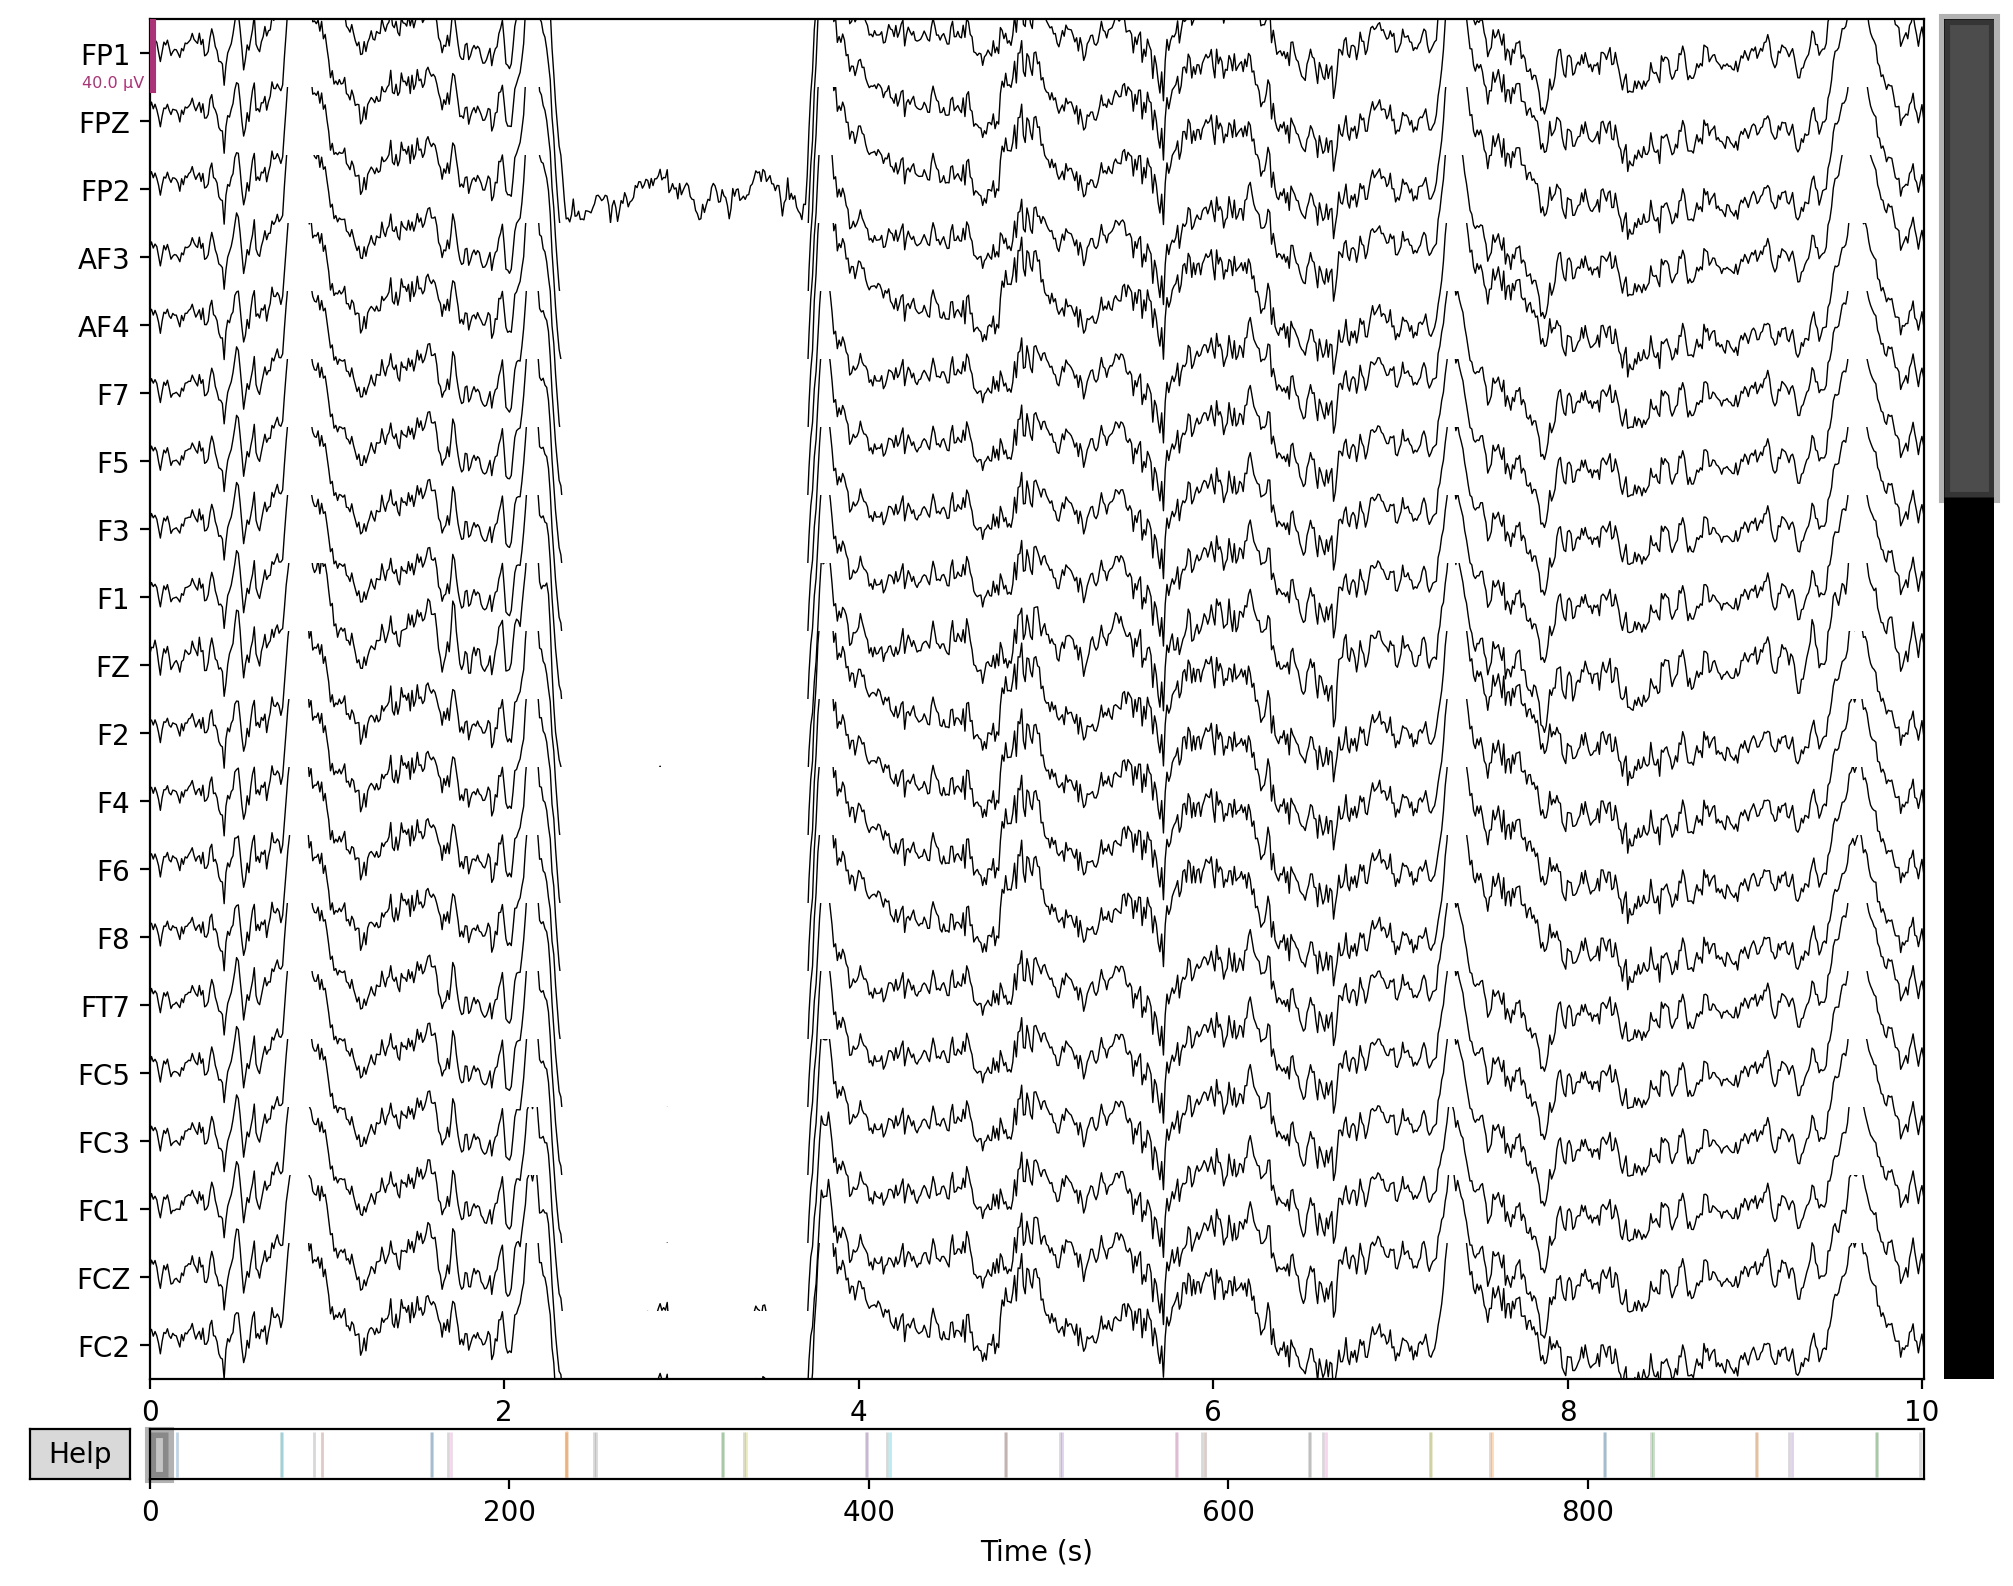

Channels marked as bad: none


In [30]:
# Step 1: Open the cnt file form of EEG data
# >> /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs
root_data_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results')
eeg_data_path = root_data_path / "EEG_ESLs"

sub_idINT = 23

cntFile = eeg_data_path / Path('S%.3d_Alice.cnt' %sub_idINT)  #'S001_Alice.cnt'  
'''
S001_Alice.cnt: 最外圈的（編號尾數7的）沒有很毛，所以不exclude
'''

raw = mne.io.read_raw_cnt(cntFile, preload=True)
#raw.load_data()
#raw.plot()
print(raw.info)
print(raw.info["ch_names"])

# Downsample to 100Hz, take off the filter, and exclude certain channels
n_raw = raw.copy()
n_raw.filter(0.1, 200, phase= 'zero-double')  # 再加0.1~30** / 1~30(訊號被扭曲的機率會更大) ，再重跑ICA
n_raw.resample(sfreq=100)
n_raw.set_eeg_reference(['M1', 'M2'])
n_raw.pick_types(eeg=True, stim=False, exclude=['M1', 'M2', 'O1', 'OZ', 'O2', 'CB1', 'CB2', 'VEO', 'HEO', 'Audio'])
# remove dc-offset                                                     # 'VEO', 'HEO', 'Audio' >> new layouts  #'HEOG', 'VEOG'

# set montage????? yes!!!
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')  # for NCU-ICN's Room 608 EEG
n_raw.set_montage(ten_twenty_montage, match_case=False)
n_raw.plot()

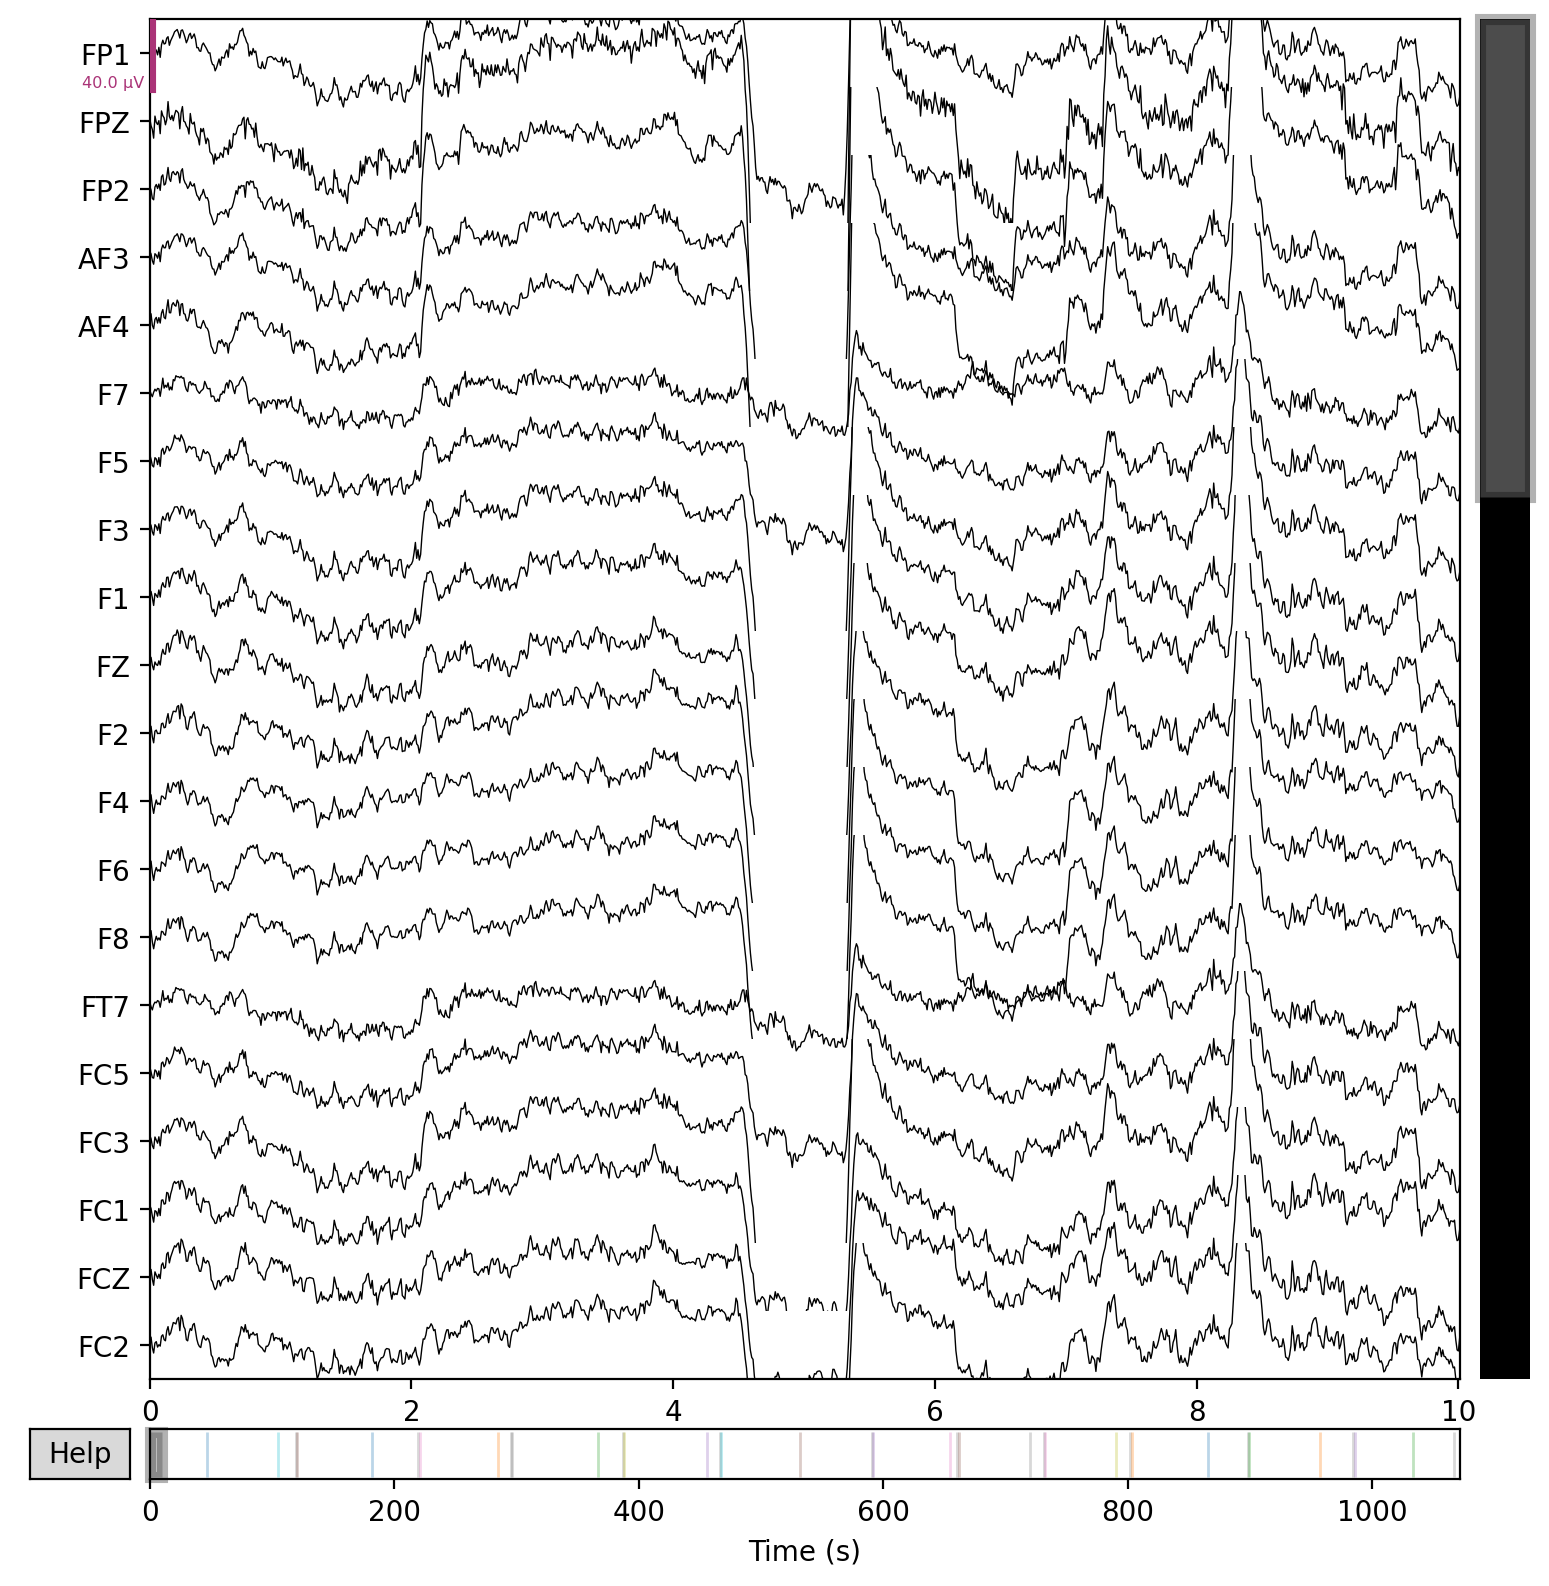

Channels marked as bad: none


In [5]:
n_raw.plot()

In [31]:
## WE NEED TO USE THE CUT FILE TO PERFORM ICA!!!

# ICA
ica_ = ICA(n_components = 15, random_state=97)
ica_.fit(n_raw)

# plot ICA
#n_raw.plot_sensors(sphere = (0.0, 0.02, 0.0, 0.065))

# Exclude certain components
ica_.plot_sources(n_raw)
ica_.plot_components(sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
#ica_.plot_overlay(n_raw, exclude=[0, 8])

Fitting ICA to data using 57 channels (please be patient, this may take a while)


/opt/anaconda3/envs/eelbrain/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/anaconda3/envs/eelbrain/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Selecting by number: 15 components
Fitting ICA took 2.2s.
Creating RawArray with float64 data, n_channels=15, n_times=98692
    Range : 0 ... 98691 =      0.000 ...   986.910 secs
Ready.


/opt/anaconda3/envs/eelbrain/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/anaconda3/envs/eelbrain/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/anaconda3/envs/eelbrain/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/anaconda3/envs/eelbrain/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/anaconda3/envs/eelbrain/lib/python3.9/site-

[<MNEFigure size 1950x1463 with 15 Axes>]

In [32]:
for i in range(15):
    #ica_.plot_properties(n_raw, picks=[i])
    ica_.plot_overlay(n_raw, exclude=[i])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 I

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components


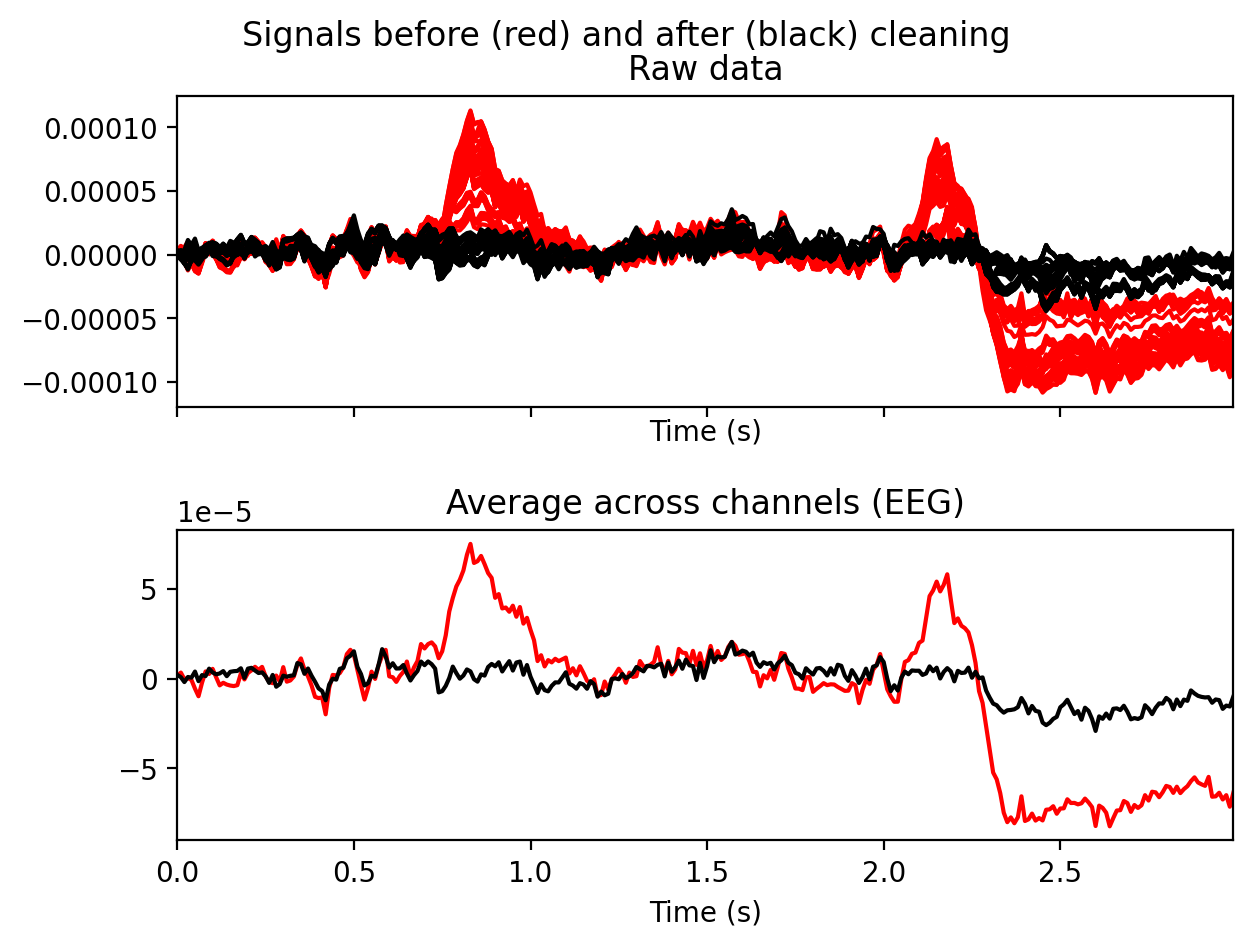

In [35]:
c_all_tmpLIST = list(range(0, 15))
#print(c_all_tmpLIST)

ica_.plot_overlay(n_raw, exclude=[0, 1, 6])
ica_.plot_overlay(n_raw, exclude=[0, 1])

In [36]:
#### What the hack is this?????

# This is the properties of each component
#ica_.plot_properties(n_raw, picks=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# apply the cleaned ICA to the data 
raw_ICAed = n_raw.copy()
ica_.exclude = [0, 1, 6]

ica_.plot_overlay(raw_ICAed, exclude=ica_.exclude)

ica_.apply(raw_ICAed)
#raw_ICAed.plot()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 57 PCA components


<RawCNT | S023_Alice.cnt, 57 x 98692 (986.9 s), ~43.0 MB, data loaded>

In [37]:
# Save the ICAed data into fif file
raw_ICAed.save(eeg_data_path/'Alice_ESL_ICAed_fif'/Path('S%.3d_ICAed_raw.fif' %sub_idINT), overwrite=True)

Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs/Alice_ESL_ICAed_fif/S023_ICAed_raw.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs/Alice_ESL_ICAed_fif/S023_ICAed_raw.fif
[done]


In [41]:
# After the ICAed file, the ESLs data needs to be cut in order to run the TRF productions
# Produce the cut_Q version of the EEG data

#root_data_path = Path('/Users/neuroling/Downloads/碩論data')
#eeg_data_path = root_data_path / "EEG_ESL"

root_data_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results')
eeg_data_path = root_data_path / "EEG_ESLs" / 'Alice_ESL_ICAed_fif'

tmpLIST = list(range(19, 24))
print(tmpLIST)

sub_idLIST = [path.name for path in eeg_data_path.iterdir() if re.match(r'S\d\d\d', path.name)]  #n_v3
print(sub_idLIST)
print(sub_idLIST[0][0:4])  # >>S001

for sub_idSTR in sub_idLIST:
    subj_data_path = eeg_data_path / Path('%s' %sub_idSTR)

    ICAed_raw = mne.io.read_raw_fif(subj_data_path, preload=True)
    events = mne.events_from_annotations(ICAed_raw)
    print(events)
    raw_sfreq = ICAed_raw.info['sfreq']
    print(raw_sfreq)
    print(type(raw_sfreq))

    events = mne.events_from_annotations(ICAed_raw)
    # covert the time points arrays into a list >> or is it better if we use it as the array??
    trigger_tPointsNDArray = events[0]  #.tolist()
    print(sub_idSTR, len(trigger_tPointsNDArray))
    
    if len(trigger_tPointsNDArray)==48:
        # Save the start % end timepoints into ndarray respectively.  
        start_tNDarray = trigger_tPointsNDArray[::4]
        print(start_tNDarray)
        print(len(start_tNDarray))

        end_tNDarray = trigger_tPointsNDArray[1::4]
        print(end_tNDarray)
        print(len(end_tNDarray))
        
        tmpLIST = []
        for points in range(12):
            print(start_tNDarray[points][0]/int(raw_sfreq), end_tNDarray[points][0]/int(raw_sfreq))
            cut_eeg = ICAed_raw.copy().crop((start_tNDarray[points][0]/int(raw_sfreq))-0.2, (end_tNDarray[points][0]/int(raw_sfreq))+0.5)
            tmpLIST.append(cut_eeg)
        cut_eegs_all = mne.concatenate_raws(tmpLIST)
        cut_eegs_all.save(eeg_data_path/Path('n_2_%s' %sub_idSTR), overwrite=True)
    
    if len(trigger_tPointsNDArray)==24:
        # Save the start % end timepoints into ndarray respectively.  
        start_tNDarray = trigger_tPointsNDArray[::2]
        print(start_tNDarray)
        print(len(start_tNDarray))

        end_tNDarray = trigger_tPointsNDArray[1::2]
        print(end_tNDarray)
        print(len(end_tNDarray))
        
        tmpLIST = []
        for points in range(12):
            print(start_tNDarray[points][0]/int(raw_sfreq), end_tNDarray[points][0]/int(raw_sfreq))
            cut_eeg = ICAed_raw.copy().crop((start_tNDarray[points][0]/int(raw_sfreq))-0.2, (end_tNDarray[points][0]/int(raw_sfreq))+0.5)
            tmpLIST.append(cut_eeg)
        cut_eegs_all = mne.concatenate_raws(tmpLIST)
        cut_eegs_all.save(eeg_data_path/Path('n_2_%s' %sub_idSTR), overwrite=True)
    else:
        pass
        #print(sub_idSTR, "is ERROR!")


[19, 20, 21, 22, 23]
['S019_ICAed_raw.fif', 'S020_ICAed_raw.fif', 'S021_ICAed_raw.fif', 'S022_ICAed_raw.fif', 'S023_ICAed_raw.fif']
S019
Opening raw data file /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs/Alice_ESL_ICAed_fif/S019_ICAed_raw.fif...
    Range : 0 ... 108195 =      0.000 ...  1081.950 secs
Ready.
Reading 0 ... 108195  =      0.000 ...  1081.950 secs...
Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '7', '8', '9', '99']
(array([[  3169,      0,      1],
       [  8970,      0,     25],
       [  9021,      0,      9],
       [ 13008,      0,     25],
       [ 13429,      0,      5],
       [ 19530,      0,     25],
       [ 19581,      0,     10],
       [ 22998,      0,     25],
       [ 23142,      0,      6],
       [ 29543,      0,     25],
       [ 29594,      0,     11],
       [ 31518,      0,     25],
       [ 31663,      0,   

S021_ICAed_raw.fif 48
[[ 1534     0     1]
 [ 9506     0     5]
 [17872     0     6]
 [26375     0     7]
 [35762     0     8]
 [43775     0    18]
 [52713     0    22]
 [60027     0    23]
 [69276     0    24]
 [77546     0     2]
 [86961     0     3]
 [96412     0     4]]
12
[[  7335      0     25]
 [ 15607      0     25]
 [ 24273      0     25]
 [ 33376      0     25]
 [ 42463      0     25]
 [ 50176      0     25]
 [ 59014      0     25]
 [ 65828      0     25]
 [ 75077      0     25]
 [ 83747      0     25]
 [ 92662      0     25]
 [101113      0     25]]
12
15.34 73.35
95.06 156.07
178.72 242.73
263.75 333.76
357.62 424.63
437.75 501.76
527.13 590.14
600.27 658.28
692.76 750.77
775.46 837.47
869.61 926.62
964.12 1011.13
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs/Alice_ESL_ICAed_fif/n_2_S021_ICAed_raw.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs/Alice_ESL_ICAed_fif/n_2_S021_ICAed_raw.fi

# ==============================================================
# Below is the TRF production section

In [ ]:
def raw2NDvar(raw, time):
  montage_x = eelbrain.load.fiff.sensor_dim(raw.info)
  temp_data = raw.get_data().T *1e+6
  eegNDVar = eelbrain.NDVar(temp_data, (time, montage_x), name='EEG', info={'unit': 'µV'})
  return eegNDVar

In [45]:
# Same scripts for I to conduct on iMac
# To check the data existence
root_data_path = Path('/Users/neuroling/Downloads/碩論data')
#eeg_data_path = root_data_path / "EEG_ESL"

sub_idLIST = [path.name for path in root_data_path.iterdir() if re.match(r'n_S\d*', path.name)]
print(sub_idLIST)

for sub_idSTR in sub_idLIST:
    subj_data_path = root_data_path / Path('%s' %sub_idSTR)

    ICAed_raw = mne.io.read_raw_fif(subj_data_path, preload=True)
    
    events = mne.events_from_annotations(ICAed_raw)
    #raw_sfreq = ICAed_raw.info['sfreq']
    print(ICAed_raw.info)
    print(events)

['n_S003_ICAed_raw.fif', 'n_S007_ICAed_raw.fif', 'n_S004_ICAed_raw.fif', 'n_S008_ICAed_raw.fif', 'n_S005_ICAed_raw.fif', 'n_S001_ICAed_raw.fif', 'n_S006_ICAed_raw.fif', 'n_S002_ICAed_raw.fif']
Opening raw data file /Users/neuroling/Downloads/碩論data/n_S003_ICAed_raw.fif...
    Range : 35346 ... 765698 =     35.346 ...   765.698 secs
Ready.
Reading 0 ... 730352  =      0.000 ...   730.352 secs...
Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', '99']
<Info | 12 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 57 EEG
 custom_ref_applied: True
 dig: 60 items (3 Cardinal, 57 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 200.0 Hz
 meas_date: 2022-10-04 07:06:47 UTC
 meas_id: 4 items (dict)
 nchan: 57
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 2 items (dict)
>
(array([[ 35446,      0,      1],
       [ 93457,      0,     13],
       [ 93558,      0,      5],
       [154570,  

    Range : 17804 ... 748157 =     17.804 ...   748.157 secs
Ready.
Reading 0 ... 730353  =      0.000 ...   730.353 secs...
Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', '99']
<Info | 12 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 57 EEG
 custom_ref_applied: True
 dig: 60 items (3 Cardinal, 57 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 200.0 Hz
 meas_date: 2022-09-04 07:11:01 UTC
 meas_id: 4 items (dict)
 nchan: 57
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 2 items (dict)
>
(array([[ 17904,      0,      1],
       [ 75915,      0,     13],
       [ 76016,      0,      5],
       [137028,      0,     13],
       [137129,      0,      6],
       [201141,      0,     13],
       [201242,      0,      7],
       [271253,      0,     13],
       [271354,      0,      8],
       [338366,      0,     13],
       [338467,      0,      9],
       [402479,      0,   

In [7]:
# Testing on every confirmed ICA components
sub_idINT_LIST = ["001", "002", "003", "004-2", "005"]
ICA_cLIST = [[0,5], [0, 1, 2, 4], [0, 8, 14], [3, 4, 5, 6, 7], [0, 8]]

for sub_idINT in sub_idINT_LIST:
    sub_idSTR = "S%.3d" 
    print(sub_idINT)
    print(type(sub_idINT))
    index = sub_idINT_LIST.index(sub_idINT)
    print(index)
    print(ICA_cLIST[index])
"""
for c in ICA_cLIST:
    #print(c)
    print(type(c))
    
    print(ICA_cLIST.index())
    """

1
<class 'str'>
0
[0, 5]
2
<class 'str'>
1
[0, 1, 2, 4]
3
<class 'str'>
2
[0, 8, 14]
4-2
<class 'str'>
3
[3, 4, 5, 6, 7]
5
<class 'str'>
4
[0, 8]


'\nfor c in ICA_cLIST:\n    #print(c)\n    print(type(c))\n    \n    print(ICA_cLIST.index())\n    '

In [20]:
# The full process of ICA with downsample 
root_data_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic')
eeg_data_path = root_data_path / "Experiments_Results/EEG"

sub_idSTR_LIST = ["001", "002", "003", "004-2", "005"]
#sub_idSTR_LIST = ["006_Alice_S002_2nd", "007_Alice_S001_2nd", "008_Alice"]
ICA_cLIST = [[0,5], [0, 1, 2, 4], [0, 8, 14], [3, 4, 5, 6, 7], [0, 8]]  # S001-005
#ICA_cLIST = [[0,2], [0,2], [0,1]]

for sub_idINT in sub_idSTR_LIST:
    #sub_idINT = 5

    cntFile = eeg_data_path / Path('S%s_Alice.cnt' %sub_idINT)  #'S001_Alice.cnt'  

    raw = mne.io.read_raw_cnt(cntFile)
    raw.load_data()
    # filter and exclude certain channels
    n_raw = raw.copy()
    n_raw.resample(sfreq=100)
    #n_raw.filter(0, 30, phase= 'zero-double')  # 再加0.1~30** / 1~30(訊號被扭曲的機率會更大) ，再重跑ICA
    n_raw.set_eeg_reference(['M1', 'M2'])
    n_raw.pick_types(eeg=True, stim=False, exclude=['M1', 'M2', 'O1', 'OZ', 'O2', 'CB1', 'CB2', 'HEOG', 'VEOG'])
                                                     # 'VEO', 'HEO', 'Audio' >> new layouts  #'HEOG', 'VEOG'
    
    # set montage????? yes!!!
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
    n_raw.set_montage(ten_twenty_montage, match_case=False)

    # ICA
    ica_ = ICA(n_components=15, random_state=97)
    ica_.fit(n_raw)
    
    c_index = sub_idSTR_LIST.index(sub_idINT)
    # apply the cleaned ICA to the data 
    ica_.exclude = ICA_cLIST[c_index]

    raw_ICAed = n_raw.copy()
    ica_.apply(raw_ICAed)
    #raw_ICAed.plot()

    # Save the ICAed data into fif file
    raw_ICAed.save(eeg_data_path/Path('S%s_sfreq-100-no-filter_ICAed_raw.fif' %sub_idINT), overwrite=True)

Reading 0 ... 824239  =      0.000 ...   824.239 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Fitting ICA to data using 57 channels (please be patient, this may take a while)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_89356/1642499229.py:30: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_.fit(n_raw)


Selecting by number: 15 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components
Overwriting existing file.
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_sfreq-100-no-filter_ICAed_raw.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_sfreq-100-no-filter_ICAed_raw.fif
[done]
Reading 0 ... 816239  =      0.000 ...   816.239 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Fitting ICA to data using 57 channels (please be patient, this may take a while)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_89356/1642499229.py:30: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_.fit(n_raw)


Selecting by number: 15 components
Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 57 PCA components
Overwriting existing file.
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S002_sfreq-100-no-filter_ICAed_raw.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S002_sfreq-100-no-filter_ICAed_raw.fif
[done]
Reading 0 ... 966479  =      0.000 ...   966.479 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Fitting ICA to data using 57 channels (please be patient, this may take a while)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_89356/1642499229.py:30: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_.fit(n_raw)


Selecting by number: 15 components
Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 57 PCA components
Overwriting existing file.
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S003_sfreq-100-no-filter_ICAed_raw.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S003_sfreq-100-no-filter_ICAed_raw.fif
[done]
Reading 0 ... 808679  =      0.000 ...   808.679 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Fitting ICA to data using 57 channels (please be patient, this may take a while)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_89356/1642499229.py:30: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_.fit(n_raw)


Selecting by number: 15 components
Fitting ICA took 20.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 5 ICA components
    Projecting back using 57 PCA components
Overwriting existing file.
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S004-2_sfreq-100-no-filter_ICAed_raw.fif


/Applications/anaconda3/envs/mne/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S004-2_sfreq-100-no-filter_ICAed_raw.fif
[done]
Reading 0 ... 829759  =      0.000 ...   829.759 secs...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_89356/1642499229.py:14: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cntFile)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Fitting ICA to data using 57 channels (please be patient, this may take a while)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_89356/1642499229.py:30: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_.fit(n_raw)


Selecting by number: 15 components
Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components
Overwriting existing file.
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S005_sfreq-100-no-filter_ICAed_raw.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S005_sfreq-100-no-filter_ICAed_raw.fif
[done]


In [3]:
# Produce the cut_Q version of the EEG data

#root_data_path = Path('/Users/neuroling/Downloads/碩論data')
#eeg_data_path = root_data_path / "EEG_ESL"

root_data_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results')
eeg_data_path = root_data_path / "EEG_ESLs" / 'Alice_ESL_ICAed_fif'

sub_idLIST = [path.name for path in eeg_data_path.iterdir() if re.match(r'S\d\d\d', path.name)]  #n_v3
print(sub_idLIST)
print(sub_idLIST[0][0:4])  # >>S001

for sub_idSTR in sub_idLIST:
    subj_data_path = eeg_data_path / Path('%s' %sub_idSTR)

    ICAed_raw = mne.io.read_raw_fif(subj_data_path, preload=True)
    events = mne.events_from_annotations(ICAed_raw)
    print(events)
    raw_sfreq = ICAed_raw.info['sfreq']
    print(raw_sfreq)
    print(type(raw_sfreq))

    events = mne.events_from_annotations(ICAed_raw)
    # covert the time points arrays into a list >> or is it better if we use it as the array??
    trigger_tPointsNDArray = events[0]  #.tolist()
    print(sub_idSTR, len(trigger_tPointsNDArray))
    
    if len(trigger_tPointsNDArray)==48:
        # Save the start % end timepoints into ndarray respectively.  
        start_tNDarray = trigger_tPointsNDArray[::4]
        print(start_tNDarray)
        print(len(start_tNDarray))

        end_tNDarray = trigger_tPointsNDArray[1::4]
        print(end_tNDarray)
        print(len(end_tNDarray))
        
        tmpLIST = []
        for points in range(12):
            print(start_tNDarray[points][0]/int(raw_sfreq), end_tNDarray[points][0]/int(raw_sfreq))
            cut_eeg = ICAed_raw.copy().crop((start_tNDarray[points][0]/int(raw_sfreq))-0.2, (end_tNDarray[points][0]/int(raw_sfreq))+0.5)
            tmpLIST.append(cut_eeg)
        cut_eegs_all = mne.concatenate_raws(tmpLIST)
        cut_eegs_all.save(eeg_data_path/Path('n_2_%s' %sub_idSTR), overwrite=True)
    
    if len(trigger_tPointsNDArray)==24:
        # Save the start % end timepoints into ndarray respectively.  
        start_tNDarray = trigger_tPointsNDArray[::2]
        print(start_tNDarray)
        print(len(start_tNDarray))

        end_tNDarray = trigger_tPointsNDArray[1::2]
        print(end_tNDarray)
        print(len(end_tNDarray))
        
        tmpLIST = []
        for points in range(12):
            print(start_tNDarray[points][0]/int(raw_sfreq), end_tNDarray[points][0]/int(raw_sfreq))
            cut_eeg = ICAed_raw.copy().crop((start_tNDarray[points][0]/int(raw_sfreq))-0.2, (end_tNDarray[points][0]/int(raw_sfreq))+0.5)
            tmpLIST.append(cut_eeg)
        cut_eegs_all = mne.concatenate_raws(tmpLIST)
        cut_eegs_all.save(eeg_data_path/Path('n_2_%s' %sub_idSTR), overwrite=True)
    else:
        pass
        #print(sub_idSTR, "is ERROR!")


['S001_ICAed_raw.fif', 'S002_ICAed_raw.fif', 'S003_ICAed_raw.fif', 'S004_ICAed_raw.fif', 'S005_ICAed_raw.fif', 'S006_ICAed_raw.fif', 'S007_ICAed_raw.fif', 'S008_ICAed_raw.fif']
S001
Opening raw data file /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs/Alice_ESL_ICAed_fif/S001_ICAed_raw.fif...
    Range : 0 ... 824239 =      0.000 ...   824.239 secs
Ready.
Reading 0 ... 824239  =      0.000 ...   824.239 secs...
Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', '99']
(array([[ 17904,      0,      1],
       [ 75915,      0,     13],
       [ 81199,      0,      5],
       [142211,      0,     13],
       [147475,      0,      6],
       [211487,      0,     13],
       [217021,      0,      7],
       [287032,      0,     13],
       [292539,      0,      8],
       [359551,      0,     13],
       [365067,      0,      9],
       [429079,      0,     13],
       [434585,      0,     10],
       [497597,     

S004_ICAed_raw.fif 24
[[  7879      0      1]
 [ 70920      0      5]
 [136962      0      6]
 [206004      0      7]
 [281046      0      8]
 [356075      0      9]
 [425600      0     10]
 [494104      0     11]
 [557609      0     12]
 [621127      0      2]
 [688621      0      3]
 [751101      0      4]]
12
[[ 65890      0     13]
 [131932      0     13]
 [200974      0     13]
 [276017      0     13]
 [348059      0     13]
 [420087      0     13]
 [488611      0     13]
 [552115      0     13]
 [615621      0     13]
 [683138      0     13]
 [745633      0     13]
 [798112      0     13]]
12
7.879 65.89
70.92 131.932
136.962 200.974
206.004 276.017
281.046 348.059
356.075 420.087
425.6 488.611
494.104 552.115
557.609 615.621
621.127 683.138
688.621 745.633
751.101 798.112
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs/Alice_ESL_ICAed_fif/n_2_S004_ICAed_raw.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Resu

S007_ICAed_raw.fif 48
[[ 26289      0      1]
 [102954      0      5]
 [178931      0      6]
 [259980      0      7]
 [339669      0      8]
 [423993      0     19]
 [504082      0     22]
 [574824      0     23]
 [643401      0     24]
 [727323      0      2]
 [803151      0      3]
 [881927      0      4]]
12
[[ 84300      0     25]
 [163965      0     25]
 [242943      0     25]
 [329992      0     25]
 [406680      0     25]
 [488004      0     25]
 [567094      0     25]
 [632835      0     25]
 [701413      0     25]
 [789334      0     25]
 [860162      0     25]
 [928938      0     25]]
12
26.289 84.3
102.954 163.965
178.931 242.943
259.98 329.992
339.669 406.68
423.993 488.004
504.082 567.094
574.824 632.835
643.401 701.413
727.323 789.334
803.151 860.162
881.927 928.938
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs/Alice_ESL_ICAed_fif/n_2_S007_ICAed_raw.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Re

In [75]:
# TESTING script, which was paste on the TRF.py file later on
# produce the NDVar from the cut EEG data
root_data_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results')
eeg_data_path = root_data_path / "EEG_ESLs" / 'Alice_ESL_ICAed_fif'

sub_idLIST = [path.name for path in eeg_data_path.iterdir() if re.match(r'n_v4S\d*', path.name)]  #n_v3
print(sub_idLIST)
idLIST = [str(i) for i in range(1, 13)]
print(idLIST)

stim_len = 73665

for sub_idSTR in sub_idLIST[:2]:
    subj_data_path = eeg_data_path / Path('%s' %sub_idSTR)
    
    ICAed_raw = mne.io.read_raw_fif(subj_data_path, preload=True)
    eeg_ = ICAed_raw.resample(sfreq=100).get_data()   # eeg_shape = (57, 737554) # already channels by times  
    #print(ICAed_raw.info)
    #print(len(ICAed_raw))
    
    if eeg_.shape[1] > stim_len:
        eeg_ = eeg_[:, :stim_len]
    
    # produce the time for NDVar production
    tstep = 1. / ICAed_raw.info['sfreq']
    n_times = eeg_.shape[1] #audio.shape[0]
    time = eelbrain.UTS(0, tstep, n_times)
    
    print(time)

    # NDVar production
    montage_x = eelbrain.load.fiff.sensor_dim(ICAed_raw.info)
    temp_data = eeg_.T *1e+6
    eegNDVar = eelbrain.NDVar(temp_data, (time, montage_x), name='EEG', info={'unit': 'µV'})
    print(eegNDVar)



['n_v4S001_ICAed_raw.fif', 'n_v4S002_ICAed_raw.fif', 'n_v4S003_ICAed_raw.fif', 'n_v4S004_ICAed_raw.fif', 'n_v4S005_ICAed_raw.fif', 'n_v4S006_ICAed_raw.fif', 'n_v4S007_ICAed_raw.fif', 'n_v4S008_ICAed_raw.fif']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Opening raw data file /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG_ESLs/Alice_ESL_ICAed_fif/n_v4S001_ICAed_raw.fif...
    Range : 17704 ... 755257 =     17.704 ...   755.257 secs
Ready.
Reading 0 ... 737553  =      0.000 ...   737.553 secs...


AttributeError: 'numpy.ndarray' object has no attribute 'np'

# ==============================================================
# Below is the Old scripts to look at trigger points and other things

In [27]:
# Load in the csv file of word onset
#csv_data_path = "/Users/neuroling/Downloads/New_thesis/Ding-Thesis_ExpMaterials/"
csv_data_path = "/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Alice(EEG dataset_mat_and stimuli)/"
with open(csv_data_path + "AliceChapterOne-EEG.csv", "r", encoding="UTF-8") as f:
    fileLIST = f.read().split("\n")
    # the average of every word length is 0.2812(s) , approximately 300 ms
    
    word_onset_tapeLIST = []
    word_onset_allLIST = []
    tape_num_allLIST = []
    word_allLIST = []
    
    #exculde the header
    fileLIST.pop(0)
    print(len(fileLIST))
    
    
    for i in range(12):
        #print(i+1)
        word_onset_tapeLIST = []
        for row in fileLIST:    
            row = row.split(",")
            #print(row)
            #print(type(row))
            
            # some factors that are needed
            wordSTR = row[0]
            tape_numINT = int(row[1])
            word_onsetFLOAT = float(row[2])
            word_seqINT = int(row[10])
            sentence_seqINT = int(row[11])
            
            #print(sentence_seqINT)
            #print(type(sentence_seqINT))
            
            if tape_numINT == i+1:
                #print(wordSTR)
                
                word_onset_tapeLIST.append(word_onsetFLOAT)
            else:
                pass
        #pprint(word_onset_tapeLIST)
        print(len(word_onset_tapeLIST))
        word_onset_allLIST.append(word_onset_tapeLIST)
    #print(word_onset_allLIST)
    print(len(word_onset_allLIST))
    #for t in range(12):
        #print(len(word_onset_allLIST[t]))


2129
174
177
184
214
193
197
178
175
156
187
157
137
12


In [29]:
def correct_time(Start_timeFLOAT, End_timeFLOAT, stim_onsetFLOAT):
    '''
    to calculate the actual epoch start & end timepoints >>> Still need more calculation(NOT YET)
    
    Start_timeFLOAT = The timepoint of the segmented data start
    End_timeFLOAT = The timepoint of the segmented data end
    stim_onsetFLOAT = Every word onset timepoints
    '''
    actual_timeFLOAT = stim_onsetFLOAT*(End_timeFLOAT-Start_timeFLOAT)+(Start_timeFLOAT)
    return actual_timeFLOAT

def tpoints2sec(timepointsINT, sampling_rateINT):
    '''
    turn the timepoints to time (second, s) by divided by the sampling rate 
    >> mne.events_from_annotations(raw) >> event array[0]
    '''
    time_secFLOAT = timepointsINT/sampling_rateINT
    
    return time_secFLOAT
    

In [30]:
# Testing the tpoints2sec function

events = mne.events_from_annotations(raw_ICAed)
#print(events)

# covert the time points arrays into a list >> or is it better if we use it as the array??
trigger_tPointsNDArray = events[0]  #.tolist()
#print(trigger_tPointsNDArray)  

# Save the start % end timepoints into ndarray respectively.  
start_tNDarray = trigger_tPointsNDArray[::4]
#print(start_tNDarray)
#print(type(start_tNDarray))

end_tNDarray = trigger_tPointsNDArray[1::4]
#print(end_tNDarray)
#print(type(end_tNDarray))
#print(len(end_tNDarray))


for k in range(12):
    start_tFLOAT = tpoints2sec(start_tNDarray[k][0], 250)
    end_tFLOAT = tpoints2sec(end_tNDarray[k][0], 250)
    print(start_tFLOAT)
    print(end_tFLOAT)


Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', '99']
10.82
68.832
143.532
207.544
288.544
355.556
430.568
493.576
562.54
620.552
693.512
750.524


IndexError: index 6 is out of bounds for axis 0 with size 6

In [10]:
trigger_tPointsNDArray, event_idDICT = mne.events_from_annotations(raw_ICAed.copy())
#print(events)

# covert the time points arrays into a list >> or is it better if we use it as the array??
#trigger_tPointsNDArray = events[0]  #.tolist()
#print(trigger_tPointsNDArray)  

# Save the start % end timepoints into ndarray respectively.  
start_tNDarray = trigger_tPointsNDArray[::4]
print("Old start t points:",start_tNDarray)
#print(type(start_tNDarray))

end_tNDarray = trigger_tPointsNDArray[1::4]
print("Old end t points:",end_tNDarray)
#print(type(end_tNDarray))
print(len(end_tNDarray))


"""

### CONTINUE LATER ###
epoch_allLIST = []

# calculate the actual word onset by applying the min max scaling formula
for i in range(2):
    print(word_onset_allLIST[i])
    
    #start_tINT = start_tNDarray[i][0]
    #end_tINT = end_tNDarray[i][0]
    
    epoch_tapeLIST = []
    for onset_t in word_onset_allLIST[i]:
        start_tFLOAT = tpoints2sec(start_tNDarray[i][0], 250)
        end_tFLOAT = tpoints2sec(end_tNDarray[i][0], 250)
        
        epoch_onset = correct_time(start_tFLOAT, end_tFLOAT, onset_t)  #/1000
        #print(epoch_onset)        
        epoch_tapeLIST.append(epoch_onset)
    print(len(word_onset_allLIST[i]))
    #print(epoch_tapeLIST)
    print(len(epoch_tapeLIST))
    
    epoch_allLIST.append(epoch_tapeLIST)
print(epoch_allLIST)
print(len(epoch_allLIST))
"""

Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '7', '8', '9', '99']
Old start t points: [[  6572      0      1]
 [ 25738      0      5]
 [ 44733      0      6]
 [ 64995      0      7]
 [ 84917      0      8]
 [105998      0     19]
 [126020      0     22]
 [143706      0     23]
 [160850      0     24]
 [181831      0      2]
 [200788      0      3]
 [220482      0      4]]
Old end t points: [[ 21075      0     25]
 [ 40991      0     25]
 [ 60736      0     25]
 [ 82498      0     25]
 [101670      0     25]
 [122001      0     25]
 [141774      0     25]
 [158209      0     25]
 [175353      0     25]
 [197334      0     25]
 [215040      0     25]
 [232234      0     25]]
12


'\n\n### CONTINUE LATER ###\nepoch_allLIST = []\n\n# calculate the actual word onset by applying the min max scaling formula\nfor i in range(2):\n    print(word_onset_allLIST[i])\n    \n    #start_tINT = start_tNDarray[i][0]\n    #end_tINT = end_tNDarray[i][0]\n    \n    epoch_tapeLIST = []\n    for onset_t in word_onset_allLIST[i]:\n        start_tFLOAT = tpoints2sec(start_tNDarray[i][0], 250)\n        end_tFLOAT = tpoints2sec(end_tNDarray[i][0], 250)\n        \n        epoch_onset = correct_time(start_tFLOAT, end_tFLOAT, onset_t)  #/1000\n        #print(epoch_onset)        \n        epoch_tapeLIST.append(epoch_onset)\n    print(len(word_onset_allLIST[i]))\n    #print(epoch_tapeLIST)\n    print(len(epoch_tapeLIST))\n    \n    epoch_allLIST.append(epoch_tapeLIST)\nprint(epoch_allLIST)\nprint(len(epoch_allLIST))\n'

In [11]:
# Creating epochs (cutting into epochs so to speak)

epoch_allLIST = []

# To calculate the actual time for every word_onset, and save it down as a bug LIST
for i in range(12):
    #start_tFLOAT = tpoints2sec(start_tNDarray[i][0], 250)
    #end_tFLOAT = tpoints2sec(end_tNDarray[i][0], 250)
    #print(start_tFLOAT)
    #print(end_tFLOAT)        
    epoch_tapeLIST = []
    
    for onset_tFLOAT in word_onset_allLIST[i]:
        #print(type(onset_tFLOAT))
        
        start_tFLOAT = tpoints2sec(start_tNDarray[i][0], 250)
        end_tFLOAT = tpoints2sec(end_tNDarray[i][0], 250)
        
        epoch_onsetFLOAT = start_tFLOAT + onset_tFLOAT  #/1000
        #print(epoch_onsetFLOAT)
        
        epoch_tapeLIST.append(epoch_onsetFLOAT)

    #print(epoch_tapeLIST)
    #print(len(epoch_tapeLIST))
    
    epoch_allLIST.append(epoch_tapeLIST)
    
#print(epoch_allLIST)
#print(len(epoch_allLIST))


In [ ]:
def newTag4word_onsetARRAY(epoch_allLIST, sampling_rate)   #, loop_counts):  #, epoch_onsetFLOAT
    '''
    Turn the word onset time into a ndarray for further epoch dissection
    
    epoch_onsetFLOAT = Coverted word onset time based on the individual's raw data (in seconds)
    sampling_rate = The sampling rate of the current data
    #loop_counts = How many times do you want to repeat the procedure = the length of the epoch_allLIST
    '''
    #loop_counts = len
    
    for i in range(len(epoch_allLIST)):
    

In [151]:
def correct_time(Start_timeFLOAT, End_timeFLOAT, stim_onsetFLOAT):
    '''
    to calculate the actual epoch start & end timepoints >>> Still need more calculation(NOT YET)
    
    Start_timeFLOAT = The timepoint of the segmented data start
    End_timeFLOAT = The timepoint of the segmented data end
    stim_onsetFLOAT = Every word onset timepoints
    '''
    actual_timeFLOAT = stim_onsetFLOAT*(End_timeFLOAT-Start_timeFLOAT)+(Start_timeFLOAT)
    return actual_timeFLOAT

# (NOT YET)calculate a more precise datapoint for future epoch calculation
import math  # for 無條件進位

for i in range(12):
    min
    for onset_tFLOAT in word_onset_allLIST[i]:
        
        tmp_timeFLOAT = (word_onsetFLOAT-word_onset_minFLOAT)/(word_onset_maxFLOAT-word_onset_minFLOAT)
    actual_timeINT = math.ceil(tmp_timeFLOAT*trigger_dINT)

"""
for i in range(12):
    tape_tagINT = 26  # for the new event_idDICT's tag  i.e "tape1_word_onset":26 etc.
    for epoch_tFLOAT in epoch_allLIST[i]:
        epoch_tPointsINT = round((epoch_tFLOAT*250), 1)
        n_epoch_tPointsINT = math.ceil(epoch_tFLOAT*250)
        #print(epoch_tPointsINT)
        #print(n_epoch_tPointsINT)
        
        onset_tPointsLIST = [n_epoch_tPointsINT, 0, tape_tagINT]
        all_onset_tPointsLIST.append(onset_tPointsLIST)
all_onset_tPointsARRAY = np.array(all_onset_tPointsLIST)
"""

SyntaxError: expected ':' (2492082761.py, line 15)

In [12]:
# calculate the word onset datapoint
import math  # for 無條件進位

all_onset_tPointsLIST = []
for i in range(12):
    tape_tagINT = 26  # for the new event_idDICT's tag  i.e "tape1_word_onset":26 etc.
    for epoch_tFLOAT in epoch_allLIST[i]:
        epoch_tPointsINT = round((epoch_tFLOAT*250), 1)
        n_epoch_tPointsINT = math.ceil(epoch_tFLOAT*250)
        #print(epoch_tPointsINT)
        #print(n_epoch_tPointsINT)
        
        onset_tPointsLIST = [n_epoch_tPointsINT, 0, tape_tagINT]
        all_onset_tPointsLIST.append(onset_tPointsLIST)
all_onset_tPointsARRAY = np.array(all_onset_tPointsLIST)

print(all_onset_tPointsARRAY[:200])
#print(len(all_onset_tPointsARRAY))
print(all_onset_tPointsARRAY.shape)


[[ 6584     0    26]
 [ 6713     0    26]
 [ 6769     0    26]
 [ 6887     0    26]
 [ 6911     0    26]
 [ 6977     0    26]
 [ 7150     0    26]
 [ 7272     0    26]
 [ 7307     0    26]
 [ 7399     0    26]
 [ 7444     0    26]
 [ 7486     0    26]
 [ 7599     0    26]
 [ 7641     0    26]
 [ 7672     0    26]
 [ 7769     0    26]
 [ 7800     0    26]
 [ 7831     0    26]
 [ 7931     0    26]
 [ 8045     0    26]
 [ 8085     0    26]
 [ 8359     0    26]
 [ 8418     0    26]
 [ 8447     0    26]
 [ 8562     0    26]
 [ 8638     0    26]
 [ 8713     0    26]
 [ 8767     0    26]
 [ 8793     0    26]
 [ 8880     0    26]
 [ 8901     0    26]
 [ 9000     0    26]
 [ 9063     0    26]
 [ 9275     0    26]
 [ 9304     0    26]
 [ 9326     0    26]
 [ 9395     0    26]
 [ 9428     0    26]
 [ 9555     0    26]
 [ 9581     0    26]
 [ 9793     0    26]
 [ 9826     0    26]
 [10017     0    26]
 [10058     0    26]
 [10100     0    26]
 [10129     0    26]
 [10174     0    26]
 [10254     0

In [13]:
#event_idDICT = events[1]
pprint(event_idDICT)
# Copy the original event id, in case any irreversible changes happened
copied_event_idDICT = event_idDICT.copy()
#print(copied_event_idDICT)

# Set up the word onset tag's event_id DICT
"""
tape_word_onsetDICT = {'tape1_word_onset': 26,
                       'tape2_word_onset': 27,
                       'tape3_word_onset': 28,
                       'tape4_word_onset': 29,
                       'tape5_word_onset': 30,
                       'tape6_word_onset': 31,
                       'tape7_word_onset': 32,
                       'tape8_word_onset': 33,
                       'tape9_word_onset': 34,
                       'tape10_word_onset': 35,
                       'tape11_word_onset': 36,
                       'tape12_word_onset': 37}
                       """
tape_word_onsetDICT = {'tape_word_onset': 26}

# Combine the original event_idDICT with the word_onset tag DICT
copied_event_idDICT.update(tape_word_onsetDICT)
pprint(copied_event_idDICT)


{'1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '50': 9,
 '51': 10,
 '52': 11,
 '53': 12,
 '54': 13,
 '55': 14,
 '56': 15,
 '57': 16,
 '58': 17,
 '59': 18,
 '6': 19,
 '60': 20,
 '61': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 '99': 25}
{'1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '50': 9,
 '51': 10,
 '52': 11,
 '53': 12,
 '54': 13,
 '55': 14,
 '56': 15,
 '57': 16,
 '58': 17,
 '59': 18,
 '6': 19,
 '60': 20,
 '61': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 '99': 25,
 'tape_word_onset': 26}


In [14]:
# Create the epochs based on the new event id
"""
tmin = -0.5                                         # pre stimulis interval (in seconds) #
tmax = 1.0                                          # post stimulus interval #

picks = mne.pick_types(raw_.info, eeg= True, stim = False)    # channels to use in epochs #
baseline = (-0.1, 0)      
reject_ = dict(eeg=100e-6) # eeg: V, meg: T                                                       # what to use as baseline comparison - here it's pre-stim interval #
epochs = mne.Epochs(raw_clean, new_events, event_id, tmin, tmax, proj = True,
                    picks = picks, baseline=baseline,
                    reject = reject_, preload = True)
"""

new_event_idDICT = tape_word_onsetDICT  #copied_event_idDICT
tmin = -0.1      # pre stimulis interval (in second) #
tmax = 0.5       # post stimulus interval (in second) # 

picks = mne.pick_types(raw_ICAed.copy().info, eeg= True, stim = False)    # channels to use in epochs #
baseline = (-0.1, 0)      
reject_ = dict(eeg=100e-6) # eeg: V, meg: T                                                       # what to use as baseline comparison - here it's pre-stim interval #
epochs = mne.Epochs(raw_ICAed.copy(), all_onset_tPointsARRAY, new_event_idDICT, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline,
                    reject=reject_, preload=True)   #reject = reject_ original
        

Not setting metadata
Not setting metadata
2129 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2129 events and 151 original time points ...
0 bad epochs dropped


In [17]:
# plotting the epochs based on each word onset in every tape
"""
# evoked based on each tape
for tapeINT in range(12):
    tape_evoked = epochs['tape%s_word_onset' %str(tapeINT+1)].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.5 )
    tape_evoked.plot_topo()
"""
# evoked of every word
tape_evoked = epochs['tape_word_onset'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.5)
tape_evoked.plot()
#tape_evoked.plot_topo()
#tape_evoked.plot_topomap()

    
    
"""
# Make a comparison
tmp = [std_evoked, devL_evoked, devS_evoked]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')
"""

Applying baseline correction (mode: mean)


"\n# Make a comparison\ntmp = [std_evoked, devL_evoked, devS_evoked]\ncolors = 'red', 'blue', 'green'\n#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))\nmne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')\n"

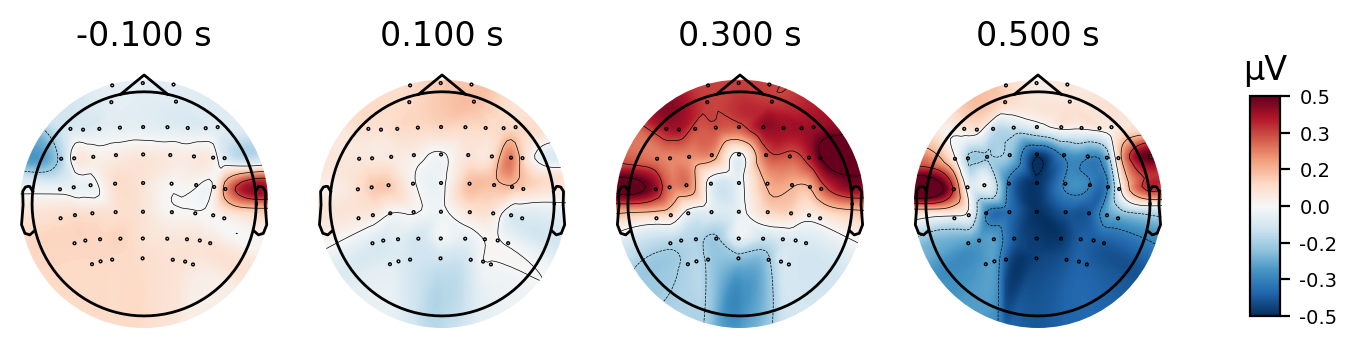

In [148]:
tape_evoked.plot_topomap()

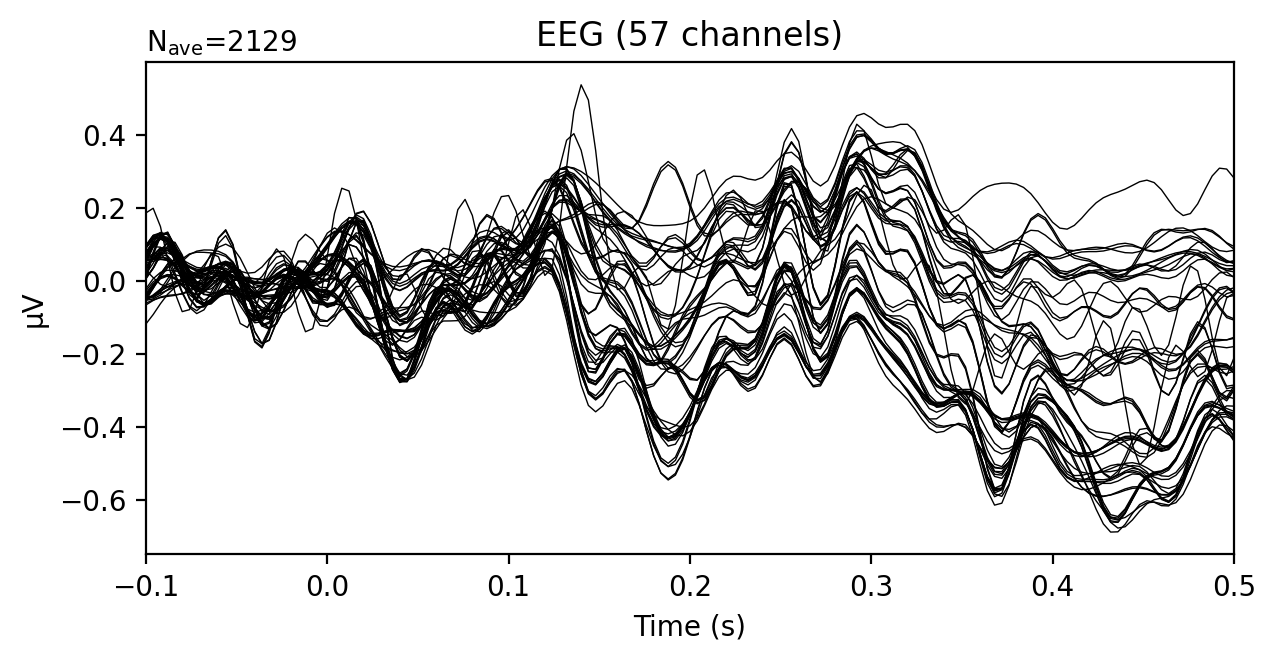

In [150]:
tape_evoked.plot()

## Below are the old codes

In [ ]:
# Use the event id >> should segment the data first??
event_id = {'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '99': 13}
#{'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '99': 13}
                                        # state which conditions match with which triggers #

# each epoch would be 300 ms long 
# >> start_timepoint = each onset, end_timepoint = onset + 0.3 
# need to recalibrate the starting time point in every part of 
tmin = -0.5                                         # pre stimulis interval (in seconds) #
tmax = 1.0                                          # post stimulus interval #

picks = mne.pick_types(raw_.info, eeg= True, stim = False)    # channels to use in epochs #
baseline = (-0.1, 0)      
reject_ = dict(eeg=100e-6) # eeg: V, meg: T                                                       # what to use as baseline comparison - here it's pre-stim interval #
epochs = mne.Epochs(raw_clean, new_events, event_id, tmin, tmax, proj = True,
                    picks = picks, baseline=baseline,
                    reject = reject_, preload = True)

In [ ]:
# see the average of the epochs, I think

std_evoked = epochs['Standard (yi3)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devL_evoked = epochs['Large deviant (yi1)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devS_evoked = epochs['Small deviant (yi2)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)

print(std_evoked)
print(devL_evoked)
print(devS_evoked)

In [22]:
# OLD VERSION OF CUTTING THE FILES

# List out the triggers #the starting and ending time point for each tape #時間要除以1000=事件發生的時間點
events = mne.events_from_annotations(raw_ICAed)
#print(events)

# covert the time points arrays into a list >> or is it better if we use it as the array??
trigger_tPointsNDArray = events[0]  #.tolist()
#print(trigger_tPointsNDArray)  

"""
dict.keys()
dict.values()
dict.items()

triggerLIST = list(range(1,13))
#print(triggerLIST)

trigger_nameDICT = events[1]
triggerkey = trigger_nameDICT.keys()
trigger_nameDICT.keys()    # the actual number mark I made for trigger
print(trigger_nameDICT.values())  # 1-25
"""

# Save the start % end timepoints into ndarray respectively.  
start_tNDarray = trigger_tPointsNDArray[::4]
print(start_tNDarray)
#print(type(start_tNDarray))
end_tNDarray = trigger_tPointsNDArray[1::4]
print(end_tNDarray)
#print(type(end_tNDarray))
print(len(end_tNDarray))

save_data_path = "/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S007_cut/"
"""
# cut the data by the timepoints
for i in range(12):
    # timepoint is in ms! (%1000 when needs to see in minute)
    start_t = start_tNDarray[i][0]/1000
    end_t = end_tNDarray[i][0]/1000
    print("start at", start_t, ";", "ends at", end_t)
    
    # cut the parts by the start & end timepoints (= save as each tapes)
    cut_file = raw_ICAed.copy().crop(tmin = start_t, tmax= end_t)
    cut_file.save(save_data_path + "S007-Alice_{}cut.fif".format(i+1), overwrite = True)
    print("DONE")
print("ALL DONE")
"""

Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '7', '8', '9', '99']
[[  6572      0      1]
 [ 25738      0      5]
 [ 44733      0      6]
 [ 64995      0      7]
 [ 84917      0      8]
 [105998      0     19]
 [126020      0     22]
 [143706      0     23]
 [160850      0     24]
 [181831      0      2]
 [200788      0      3]
 [220482      0      4]]
[[ 21075      0     25]
 [ 40991      0     25]
 [ 60736      0     25]
 [ 82498      0     25]
 [101670      0     25]
 [122001      0     25]
 [141774      0     25]
 [158209      0     25]
 [175353      0     25]
 [197334      0     25]
 [215040      0     25]
 [232234      0     25]]
12


'\n# cut the data by the timepoints\nfor i in range(12):\n    # timepoint is in ms! (%1000 when needs to see in minute)\n    start_t = start_tNDarray[i][0]/1000\n    end_t = end_tNDarray[i][0]/1000\n    print("start at", start_t, ";", "ends at", end_t)\n    \n    # cut the parts by the start & end timepoints (= save as each tapes)\n    cut_file = raw_ICAed.copy().crop(tmin = start_t, tmax= end_t)\n    cut_file.save(save_data_path + "S007-Alice_{}cut.fif".format(i+1), overwrite = True)\n    print("DONE")\nprint("ALL DONE")\n'

In [ ]:
tmp = [std_evoked, devL_evoked, devS_evoked]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')